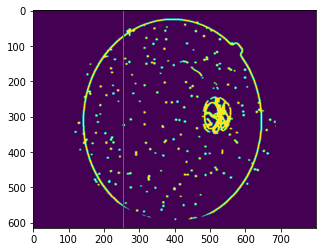

In [1]:
from numba import jit
from csv import *
from sklearn import preprocessing
from scipy import signal
import cv2
import sys
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import os
from PIL import Image
import xlrd 
import math
from pylab import*
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from skimage import data
from pathlib import Path


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
pixel = []
dataDTC = []

def edge_pixel_image(image,bv_image):
	edge_result = image.copy()
	edge_result = cv2.Canny(edge_result,30,100)	
	i = 0
	j = 0
	while i < image.shape[0]:
		j = 0
		while j < image.shape[1]:
			if edge_result[i,j] == 255 and bv_image[i,j] == 255:
				edge_result[i,j] = 0
			j = j+1
		i = i+1
	newfin = cv2.dilate(edge_result, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
	return newfin

def extract_bv(image):			
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	contrast_enhanced_green_fundus = clahe.apply(image)
	# applying alternate sequential filtering (3 times closing opening)
	r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
	f5 = clahe.apply(f4)
    
	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255
	contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)

	# removing blobs of microaneurysm & unwanted bigger chunks taking in consideration they are not straight lines like blood
	# vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)
	xmask = np.ones(image.shape[:2], dtype="uint8") * 255
	xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)

	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)
	blood_vessels = cv2.bitwise_not(finimage)
	dilated = cv2.erode(blood_vessels, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations=1)
	blood_vessels_1 = cv2.bitwise_not(dilated)
	return finimage #blood_vessels_1


def exudate_img(image):
    fundus = cv2.resize(image,(800,615))
    fundus_mask = cv2.imread("./MASK.bmp")
    fundus_mask = cv2.resize(fundus,(800,615))
    f1 = cv2.bitwise_and(fundus[:,:,0],fundus_mask[:,:,0])
    f2 = cv2.bitwise_and(fundus[:,:,1],fundus_mask[:,:,1])
    f3 = cv2.bitwise_and(fundus[:,:,2],fundus_mask[:,:,2])
    fundus_dash = cv2.merge((f1,f2,f3))
    
    b,g,r = cv2.split(fundus_dash)	
    gray_scale = cv2.cvtColor(fundus_dash,cv2.COLOR_BGR2GRAY)
    cv2.imwrite('./keeptest/Mook2.jpg',gray_scale)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced_fundus = clahe.apply(gray_scale)	
    contrast_enhanced_green_fundus = clahe.apply(g)
    bv_image_dash = extract_bv(g)
    bv_image = extract_bv(gray_scale)
    cv2.imwrite('./keeptest/Mook3.jpg', bv_image)
    edge_feature_output = edge_pixel_image(gray_scale,bv_image)
    
    newfin = cv2.dilate(edge_feature_output, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations=1)
    edge_candidates = cv2.erode(newfin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)
    edge_candidates = np.uint8(edge_candidates)	
    
    mask = np.ones((615, 800)) * 255
    mask = np.uint8(mask)
    mask = cv2.circle(mask, (400,307), 537, (0, 0, 0), 500)
    exudate = cv2.bitwise_and(mask, edge_candidates)
    histogram = plt.hist(exudate.ravel(), 256, [0,256])
    show = plt.imshow(exudate)
    return histogram[0][255]



def segment(image):
    Abo,Ago,Aro = cv2.split(image)  #splitting into 3 channels
    cv2.imwrite('./keeptest/GlaucomaRed.jpg', Aro)
    Ago = clahe.apply(Ago)
    M = 60   #filter size
    filter = signal.gaussian(M, std=6) #Gaussian Window
    filter = filter/sum(filter)
    STDf =  filter.std()  #It'standard deviation
    
    Ar = Aro - Aro.mean() - Aro.std()        #Preprocessing Red   
    Mr = Ar.mean()                           #Mean of preprocessed red
    SDr = Ar.std()                           #SD of preprocessed red
    Thr = M - 0.5*STDf - 0.09*SDr             #Optic disc Threshold

    Ag = Ago - Ago.mean() - Ago.std()		 #Preprocessing Green
    Mg = Ag.mean()                           #Mean of preprocessed green
    SDg = Ag.std()                           #SD of preprocessed green
    Thg = Mg + 0.5*STDf + 2*SDg        #Optic Cup Threshold

    r,c = Ag.shape
    Dd = np.zeros(shape=(r,c)) #Segmented disc image initialization
    Dc = np.zeros(shape=(r,c)) #Segmented cup image initialization

    #Using obtained threshold for thresholding of the fundus image
    for i in range(1,r):
        for j in range(1,c):
            if Ar[i,j]>=Thr:
                Dd[i,j]=255
            else:
                Dd[i,j]=0
            Dd = Ar

    for i in range(1,r):
        for j in range(1,c):
            
            if Ag[i,j]>=Thg:
                Dc[i,j]=255
            else:
                Dc[i,j]=0
            Dc = Ag

    #morphological closing and opening operations
    R1 = cv2.morphologyEx(Dc, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)	
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 0)
   
    ret,thresh = cv2.threshold(r1,127,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(np.uint8(thresh), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #Getting all possible contours in the segmented image
    cup_diameter = 0
    largest_area = 0
    el_cup = contours[0]
    i = 0
    if len(contours) >= 0:
        for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv2.contourArea(contours[i]) #Getting the contour with the largest area
                if (area>largest_area):
                    largest_area=area
                    index = i
                    el_cup = cv2.fitEllipse(contours[i])

    cv2.ellipse(image,el_cup,(0,255,0),2)  #fitting ellipse with the largest area
    x,y,w,h = cv2.boundingRect(contours[index]) #1
    cup_diameter = max(w,h) #major axis is the diameter
    cup_area = cup_diameter**2 * math.pi

    #morphological closing and opening operations
    R1 = cv2.morphologyEx(Dd, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2)), iterations = 1)
    r1 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    R2 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,21)), iterations = 1)
    r2 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,1)), iterations = 1)
    R3 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33)), iterations = 1)
    r3 = cv2.morphologyEx(R3, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(43,43)), iterations = 0)

       
    ret,thresh = cv2.threshold(r1,127,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(np.uint8(thresh), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #Getting all possible contours in the segmented image
    disk_diameter = 0
    largest_area = 0
    el_disc = el_cup
    if len(contours) != 0:
        for i in range(len(contours)):
            if len(contours[i]) >= 5:
                area = cv2.contourArea(contours[i]) #Getting the contour with the largest area
                if (area>largest_area):
                    largest_area=area
                    index = i
                    el_disc = cv2.fitEllipse(contours[i])
                        
    cv2.ellipse(image,el_disc,(0,255,0),2) #fitting ellipse with the largest area
    plt.imshow(image)
    x,y,w,h = cv2.boundingRect(contours[index]) #fitting a rectangle on the ellipse to get the length of major axis
    disc_diameter = max(w,h) #major axis is the diameter
    disc_area = disc_diameter**2 * math.pi
    cup_to_disc_ratio = cup_area/disc_area
    dataDTC.append('%.2f' %cup_to_disc_ratio)
    return "%.4f"%cup_to_disc_ratio

image = 'GlacumaAll 2 fea เอา/GlacumaGrain 110.jpg'
img = cv2.imread(str(image))
im2 = segment(img)
im1 = exudate_img(img)

#image_paths = list(Path('./Glacumaไม่แน่ใจจะเอามั้ย').iterdir())  #load images from folder 
#image = [read_image(p) for p in image_paths]
#images = [segment(p) for p in image] 
#image_exudate = [exudate_img(p) for p in image] 

